This notebook makes the radial plots of the SHAP Maps and the associated SFHs of the galaxys

In [88]:
import hickle
import pandas as pd
import scipy.signal
import shap
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import FormatStrFormatter
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from astropy.table import Table
from scipy import ndimage
from tqdm import tqdm
import statistics
import george 
import dense_basis as db
work_dir = '/home/juanpabloalfonzo/Documents/Manga CNNs/Catalogues/'

Starting dense_basis. please wait ~ a minute for the FSPS backend to initialize.
running without emcee


In [2]:
filepath = work_dir+'scalars.cat'
d = hickle.load(filepath)

In [ ]:
manga_scalars = pd.DataFrame(d)
manga_scalars

In [4]:
filepath = work_dir + 'images.cat'
d_im = hickle.load(filepath)

In [5]:
filepath = work_dir + 'shap_mass.cat'
d_shapmass = hickle.load(filepath)

In [6]:
filepath = work_dir + 'shap_sfr.cat'
d_shapsfr = hickle.load(filepath)

In [7]:
filepath = work_dir + 'shap_d4000.cat'
d_shapage = hickle.load(filepath)

In [93]:
def get_xax(z, nspaxels = 179):
    """
    Convert angular separation to physical distance at a given redshift (z)
    
    """
    spaxel_size = 0.5  # [arcsec]
    c = 299792  # speed of light [km/s]
    H0 = 70  # [km s^-1 Mpc^-1]
    D = c * z / H0  # a
    scale = 1 / 206265 * D * 1e6  # 1 radian = 206265 arcsec [pc / arcsec]
#     spaxel_area = (scale * spaxel_size)**2  # [pc^2]
    return np.arange(nspaxels) * (scale*spaxel_size) / 1e3 # return in kpc

def azimuthalAverage(image, center=None):
    """
    Calculate the azimuthally averaged radial profile.
    from: https://github.com/mkolopanis/python/blob/master/radialProfile.py 

    image - The 2D image
    center - The [x,y] pixel coordinates used as the center. The default is 
             None, which then uses the center of the image (including 
             fracitonal pixels).
    
    """
    # Calculate the indices from the image
    y, x = np.indices(image.shape)

    if not center:
        center = np.array([(x.max()-x.min())/2.0, (y.max()-y.min())/2.0])

    r = np.hypot(x - center[0], y - center[1])

    # Get sorted radii
    ind = np.argsort(r.flat)
    r_sorted = r.flat[ind]
    i_sorted = image.flat[ind]

    # Get the integer part of the radii (bin size = 1)
    r_int = r_sorted.astype(int)

    # Find all pixels that fall within each radial bin.
    deltar = r_int[1:] - r_int[:-1]  # Assumes all radii represented
    rind = np.where(deltar)[0]       # location of changed radius
    nr = rind[1:] - rind[:-1]        # number of radius bin
    
    # Cumulative sum to figure out sums for each radius bin
    csim = np.cumsum(i_sorted, dtype=float)
    tbin = csim[rind[1:]] - csim[rind[:-1]]

    radial_prof = tbin / nr

    return radial_prof

def calculate_average_across_arrays(array_of_arrays):
    # Determine the number of arrays
    num_arrays = len(array_of_arrays)

    # Determine the length of each array
    array_length = len(array_of_arrays[0])

    # Create an empty array to store the averages
    averages = []

    # Iterate over the indices of the sub-arrays
    for i in range(array_length):
        # Initialize a sum for the current index
        total = 0
        # Iterate over the sub-arrays and sum the values at the current index
        for j in range(num_arrays):
            total += array_of_arrays[j][i]
        # Calculate the average for the current index and append to the 'averages' array
        avg = total / num_arrays
        averages.append(avg)

    return averages

def calculate_median_across_arrays(array_of_arrays):
    # Determine the length of each array
    array_length = len(array_of_arrays[0])

    # Create an empty array to store the medians
    medians = []

    # Iterate over the indices of the sub-arrays
    for i in range(array_length):
        # Get the values at the current index across the sub-arrays
        values_at_index = [arr[i] for arr in array_of_arrays]
        # Calculate the median for the current index and append to the 'medians' array
        median = statistics.median(values_at_index)
        medians.append(median)

    return medians

def make_radial_shapplot(mv, massbins, clabel, 
                         zbin = 0.02, zbw = 0.01, mbw = 0.5):
    
    zv = manga_scalars['redshift']
    colors = cm.Spectral(np.linspace(0,1,len(massbins)))

    fig, ax = plt.subplots(1,3, figsize=(21,9))
    plt.subplot(1,3,1)
    plt.axhline(0,color='k',alpha=0.3)
    for i, mb in enumerate(massbins):
        mask = (np.abs(zv-zbin) < zbw) & (np.abs(mv-mb) < mbw)
        plt.plot(get_xax(0.02), np.nanmedian(mass_avgs[mask,0:],0),lw=3, color=colors[i])
    plt.xscale('log')
    plt.yscale('symlog')
    plt.xlabel('distance from center [kpc]',fontsize=14); 
    plt.ylabel('SHAP (M$_*$)',fontsize=14)
    plt.xlim(1e-1,0.4e2)

    plt.subplot(1,3,2)
    plt.axhline(0,color='k',alpha=0.3)
    for i, mb in enumerate(massbins):
        mask = (np.abs(zv-zbin) < zbw) & (np.abs(mv-mb) < mbw)
        plt.plot(get_xax(0.02), np.nanmedian(sfr_avgs[mask,0:],0),lw=3, color=colors[i])
    plt.xscale('log')
    plt.yscale('symlog')
    plt.xlabel('distance from center [kpc]',fontsize=14); 
    plt.ylabel('SHAP (SFR)',fontsize=14)
    plt.xlim(1e-1,0.4e2)

    plt.subplot(1,3,3)
    plt.axhline(0,color='k',alpha=0.3)
    for i, mb in enumerate(massbins):
        mask = (np.abs(zv-zbin) < zbw) & (np.abs(mv-mb) < mbw)
        plt.plot(get_xax(0.02), np.nanmedian(d4000_avgs[mask,0:],0),lw=3, color=colors[i])
    plt.xscale('log')
    plt.yscale('symlog')
    plt.xlabel('distance from center [kpc]',fontsize=14); 
    plt.ylabel('SHAP (d4000)',fontsize=14)
    plt.xlim(1e-1,0.4e2)
    ax[2].yaxis.set_major_formatter(FormatStrFormatter('%.2g'))

    # ----------------------------------------------------------
    im1 = plt.scatter(massbins*1000, np.zeros_like(massbins), c=massbins, cmap='Spectral')
    axins1 = inset_axes(
        ax[2],
        width="70%",  # width: 50% of parent_bbox width
        height="2%",  # height: 5%
        loc="upper right", borderpad=1.2
    )
    axins1.xaxis.set_ticks_position("both")
    clbr = fig.colorbar(im1, cax=axins1, orientation="horizontal")
    clbr.set_label(clabel)
    plt.tight_layout()
    plt.show()

def SFH_plot(bins,target):
    num_bins = len(bins)
    colors = cm.Spectral(np.linspace(0,1,len(bins)))
    bin_indices = []
    
    if target == 'ssfr':
        for i in range(num_bins - 1):
            lower_bound = bins[i]
            upper_bound = bins[i + 1]
            
            bin_index = np.where(
                (np.array(manga_scalars['log_sfr']-manga_scalars['log_mstar']) > lower_bound) &
                (np.array(manga_scalars['log_sfr']-manga_scalars['log_mstar']) <= upper_bound)
            )[0]
            
            bin_indices.append(bin_index)

    else:
        for i in range(num_bins - 1):
            lower_bound = bins[i]
            upper_bound = bins[i + 1]
            
            bin_index = np.where(
                (np.array(manga_scalars[target]) > lower_bound) &
                (np.array(manga_scalars[target]) <= upper_bound)
            )[0]
            
            bin_indices.append(bin_index)
    
    # Now bin_indices is a list of arrays containing indices for each bin
    
    # You can loop through bin_indices, extract data, and perform calculations
    plt.figure(figsize=(21,10))
    for i, index in enumerate(bin_indices):
        sfh = []
        for j in range(len(np.array(manga_scalars['sfh'])[index])):
            if str(np.array(manga_scalars['sfh'])[index][j]) != 'None':
                sfh.append(np.array(manga_scalars['sfh'])[index][j][1])

        try:
            sfh_avg = np.array(calculate_average_across_arrays(np.array(sfh,dtype=object)))
            # print(sfh_avg)
            plt.plot(np.array(manga_scalars['sfh'])[index][0][0][:990],sfh_avg[:990]/np.max(sfh_avg), label = str(bins[i])[0:6] + ' - ' + str(bins[i+1])[0:6],color = colors[i])
        except: 
            print('No galaxies in bin ' + str(bins[i])[0:6] + ' - ' + str(bins[i+1])[0:6])

    plt.legend()
    plt.title('SFH of Galaxies in Each Bin (Normalized)')
    plt.xlabel('Cosmic Time (Gyr)')
    plt.ylabel('SFR')
       
def SFH_plot_median(bins,target):
    num_bins = len(bins)
    colors = cm.Spectral(np.linspace(0,1,len(bins)))
    bin_indices = []
    
    if target == 'ssfr':
        for i in range(num_bins - 1):
            lower_bound = bins[i]
            upper_bound = bins[i + 1]
            
            bin_index = np.where(
                (np.array(manga_scalars['log_sfr']-manga_scalars['log_mstar']) > lower_bound) &
                (np.array(manga_scalars['log_sfr']-manga_scalars['log_mstar']) <= upper_bound)
            )[0]
            
            bin_indices.append(bin_index)

    else:
        for i in range(num_bins - 1):
            lower_bound = bins[i]
            upper_bound = bins[i + 1]
            
            bin_index = np.where(
                (np.array(manga_scalars[target]) > lower_bound) &
                (np.array(manga_scalars[target]) <= upper_bound)
            )[0]
            
            bin_indices.append(bin_index)
    
    # Now bin_indices is a list of arrays containing indices for each bin
    
    # You can loop through bin_indices, extract data, and perform calculations
    plt.figure(figsize=(21,10))
    for i, index in enumerate(bin_indices):
        sfh = []
        for j in range(len(np.array(manga_scalars['sfh'])[index])):
            if str(np.array(manga_scalars['sfh'])[index][j]) != 'None':
                sfh.append(np.array(manga_scalars['sfh'])[index][j][1])

        try:
            sfh_avg = np.array(calculate_median_across_arrays(np.array(sfh,dtype=object)))
            # print(sfh_avg)
            plt.plot(np.array(manga_scalars['sfh'])[index][0][0][:990],sfh_avg[:990]/np.max(sfh_avg), label = str(bins[i])[0:6] + ' - ' + str(bins[i+1])[0:6],color = colors[i])
        except: 
            print('No galaxies in bin ' + str(bins[i])[0:6] + ' - ' + str(bins[i+1])[0:6])

    plt.legend()
    plt.title('SFH of Galaxies in Each Bin (Normalized)')

# Collect all the maps in one place

In [11]:
mass_avgs = []
sfr_avgs = []
d4000_avgs = []
sigma = 2.0
for i in tqdm(range(len(d_shapmass['shap_map_mass']))):
    try:
        temp = np.mean(ndimage.gaussian_filter(d_shapmass['shap_map_mass'][i]*1e4, sigma, mode='nearest'),2)
        mass_avgs.append(azimuthalAverage(temp))
        temp = np.mean(ndimage.gaussian_filter(d_shapsfr['shap_map_mass'][i]*1e4, sigma, mode='nearest'),2)
        sfr_avgs.append(azimuthalAverage(temp))
        temp = np.mean(ndimage.gaussian_filter(d_shapage['shap_map_mass'][i]*1e4, sigma, mode='nearest'),2)
        d4000_avgs.append(azimuthalAverage(temp))
    except:
        mass_avgs.append(np.ones((179,))*np.nan)
        sfr_avgs.append(np.ones((179,))*np.nan)
        d4000_avgs.append(np.ones((179,))*np.nan)
mass_avgs = np.array(mass_avgs)
sfr_avgs = np.array(sfr_avgs)
d4000_avgs = np.array(d4000_avgs)

100%|██████████| 10081/10081 [06:31<00:00, 25.72it/s]


# Primary trained properties

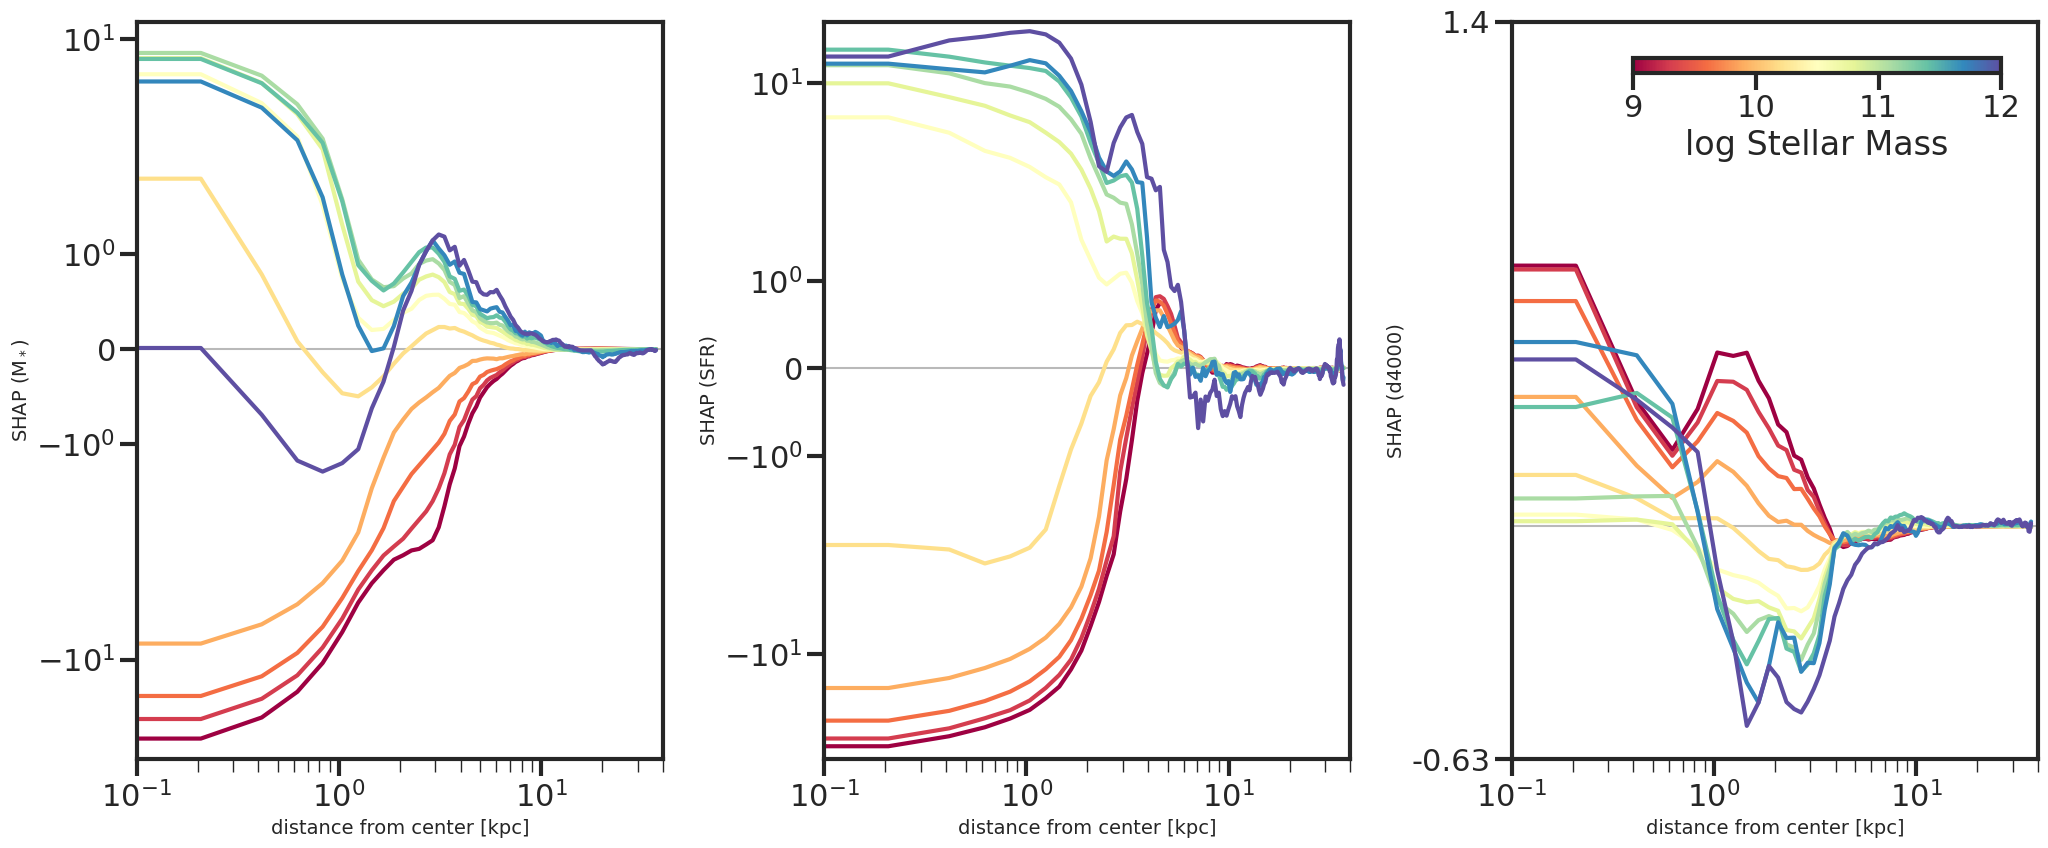

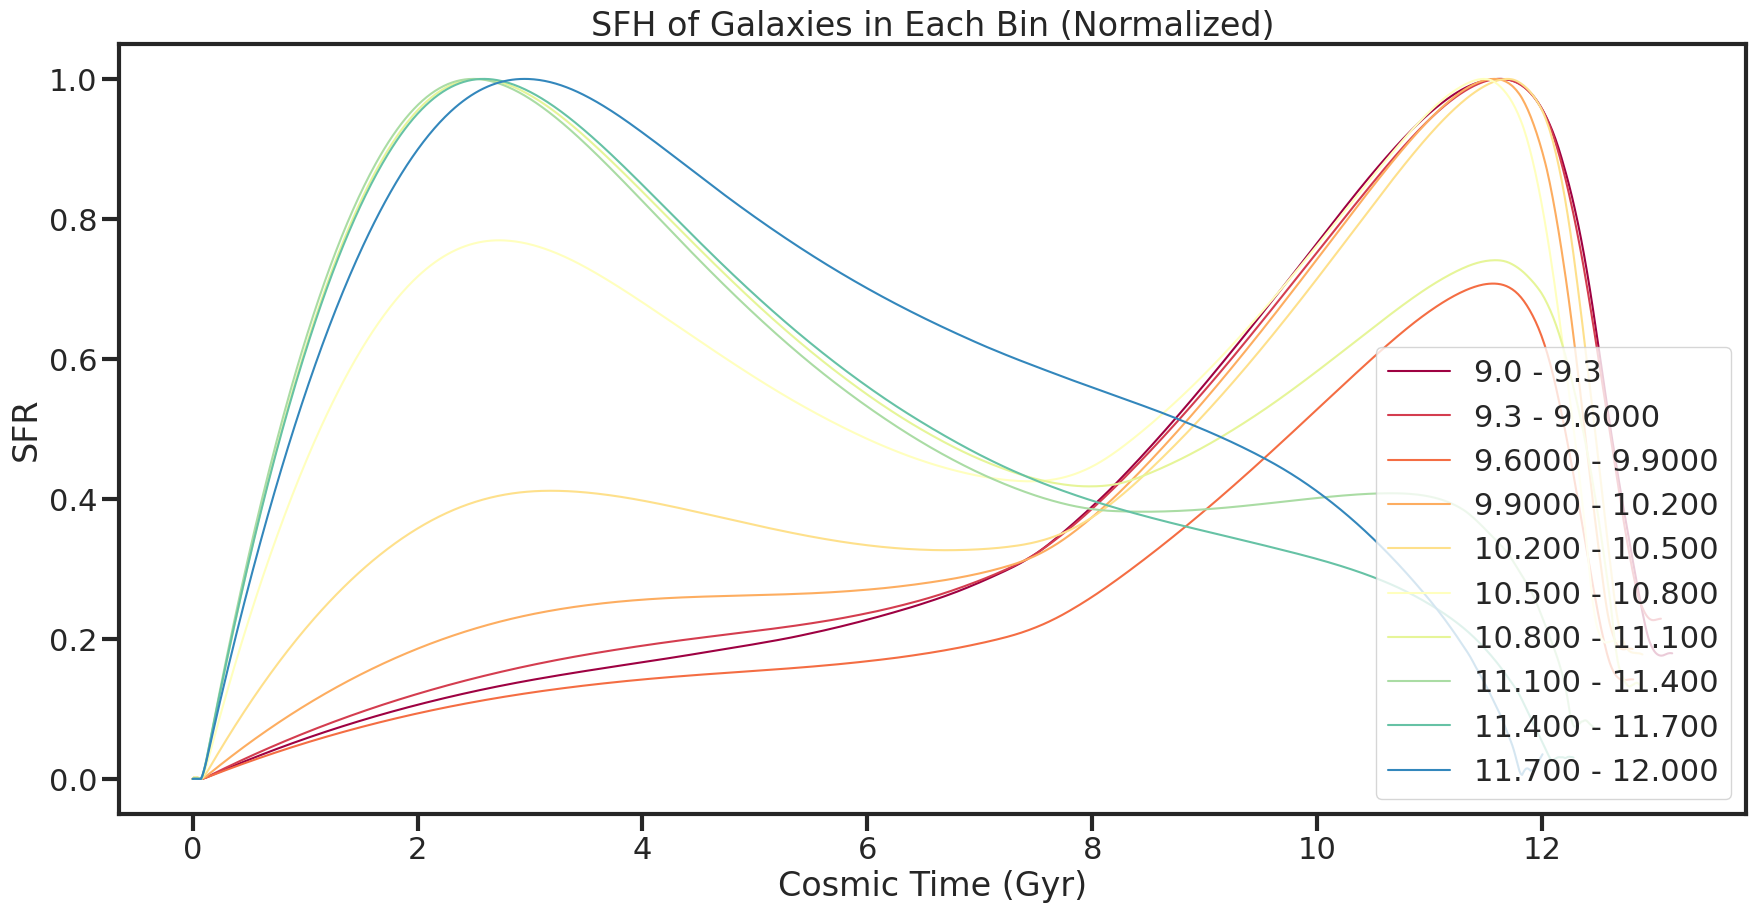

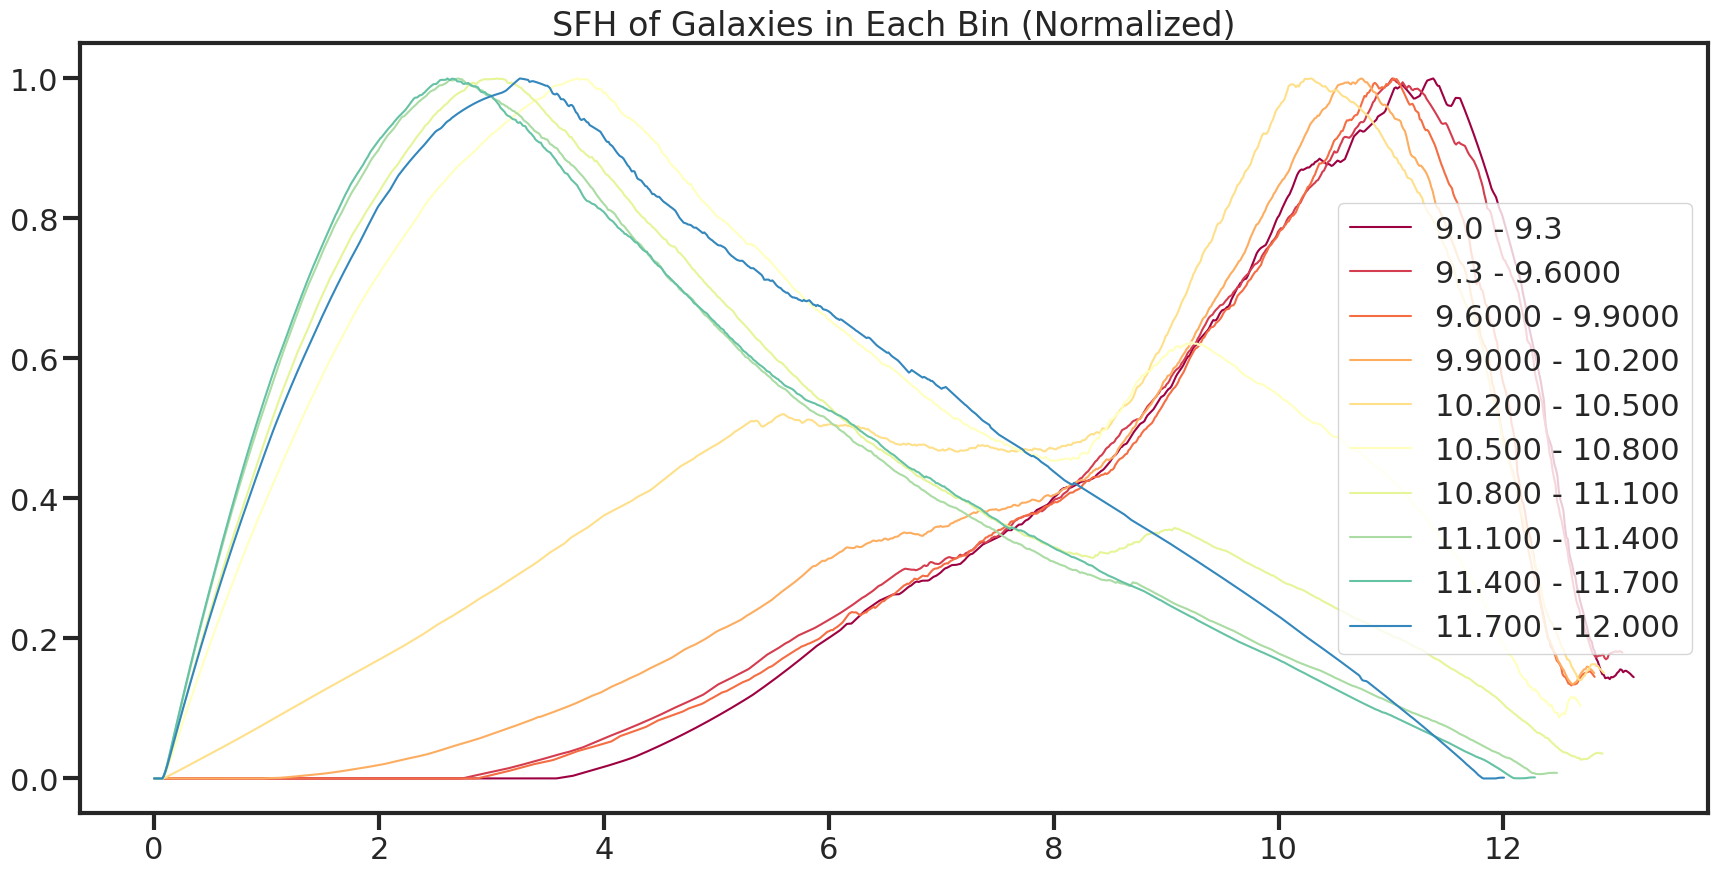

In [94]:
make_radial_shapplot(mv = manga_scalars['log_mstar'], 
                     massbins = np.arange(9,12.1,0.3),
                     clabel = 'log Stellar Mass')

SFH_plot(np.arange(9,12.1,0.3),'log_mstar')
SFH_plot_median(np.arange(9,12.1,0.3),'log_mstar')

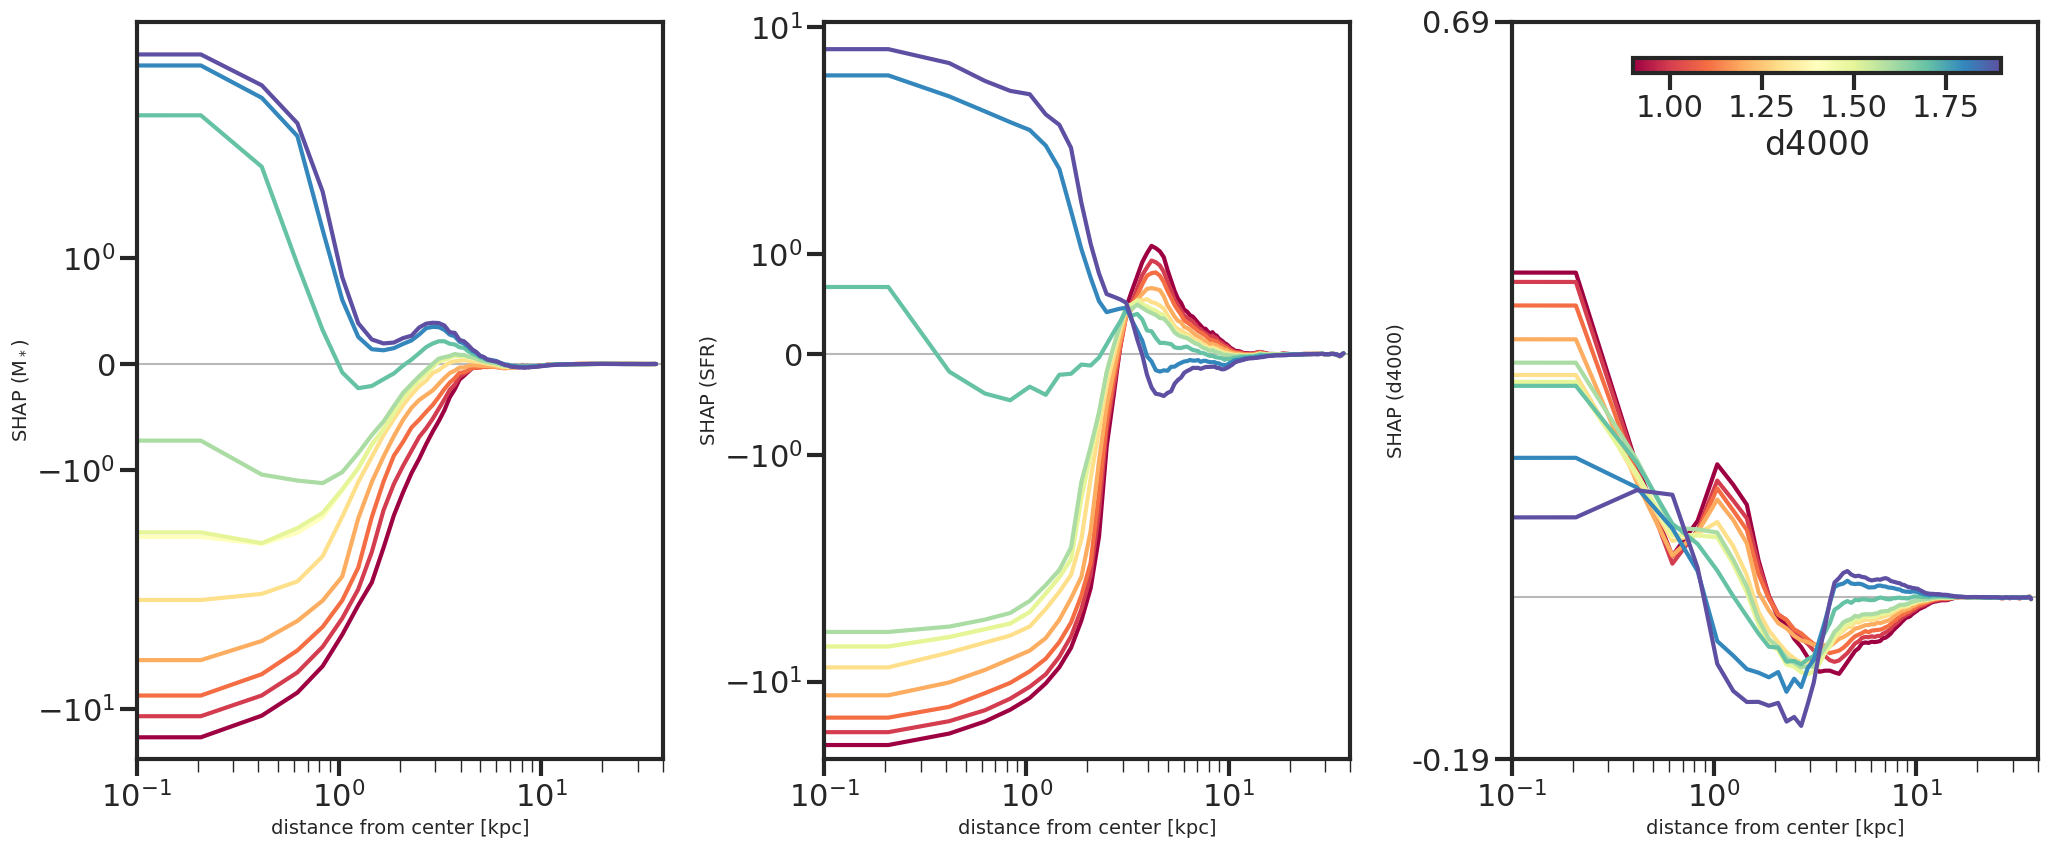

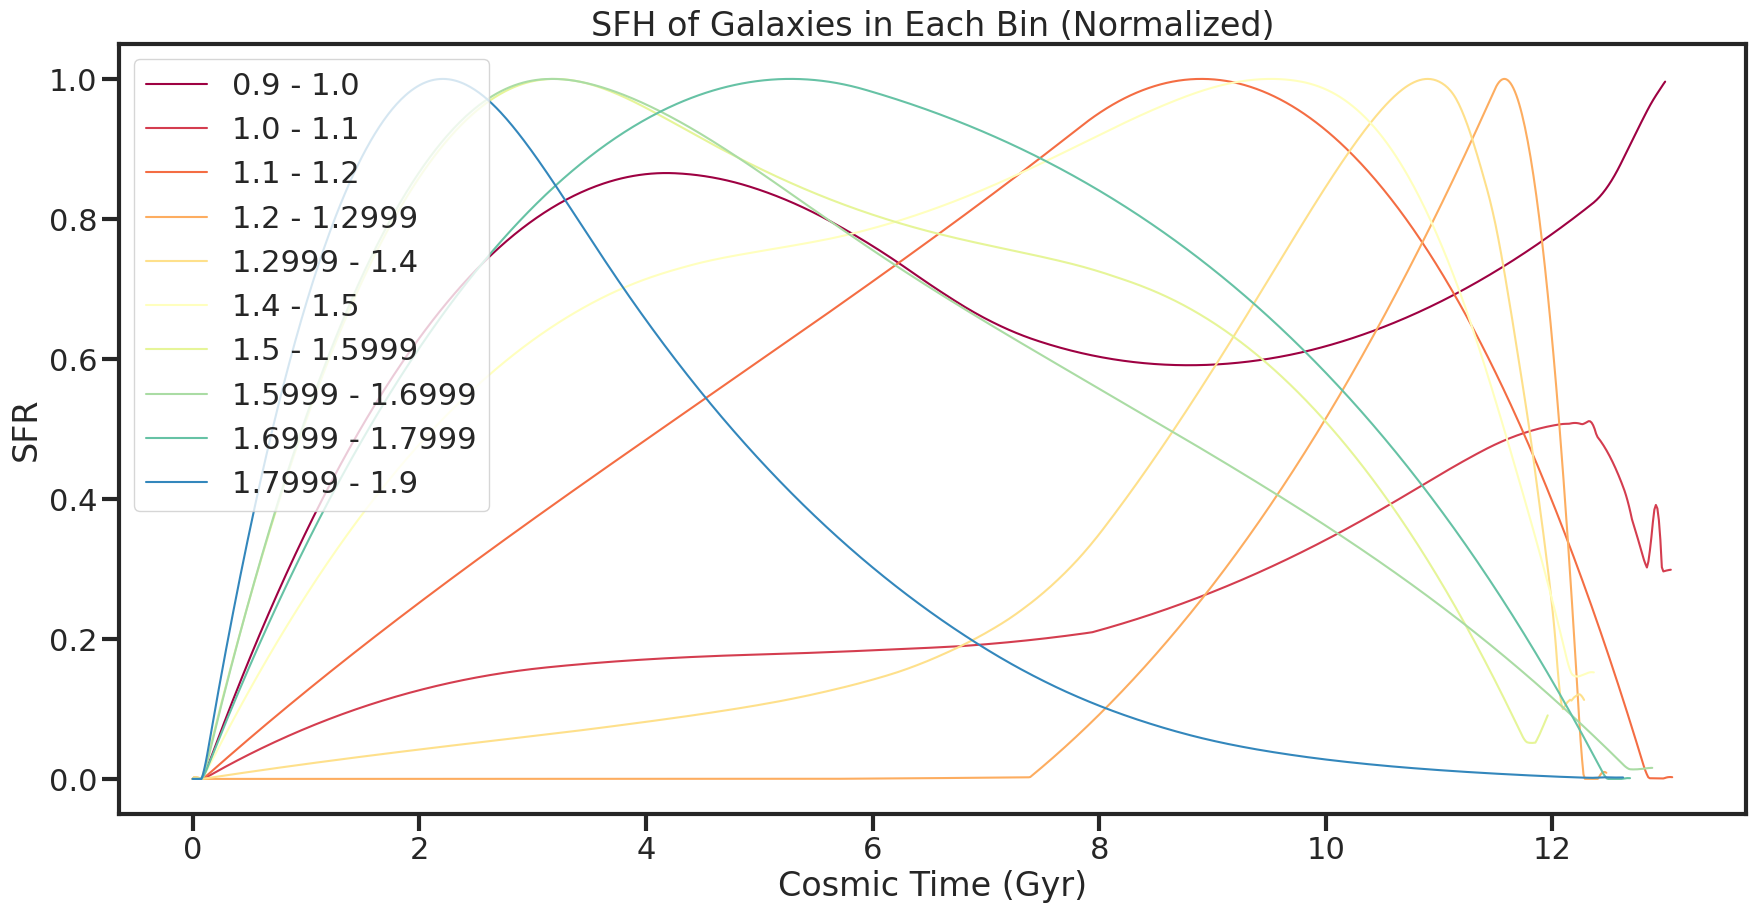

In [95]:
make_radial_shapplot(mv = manga_scalars['d4000'], 
                     massbins = np.arange(0.9, 2.0, 0.1),
                     clabel = 'd4000')

SFH_plot(np.arange(0.9, 2.0, 0.1),'d4000')

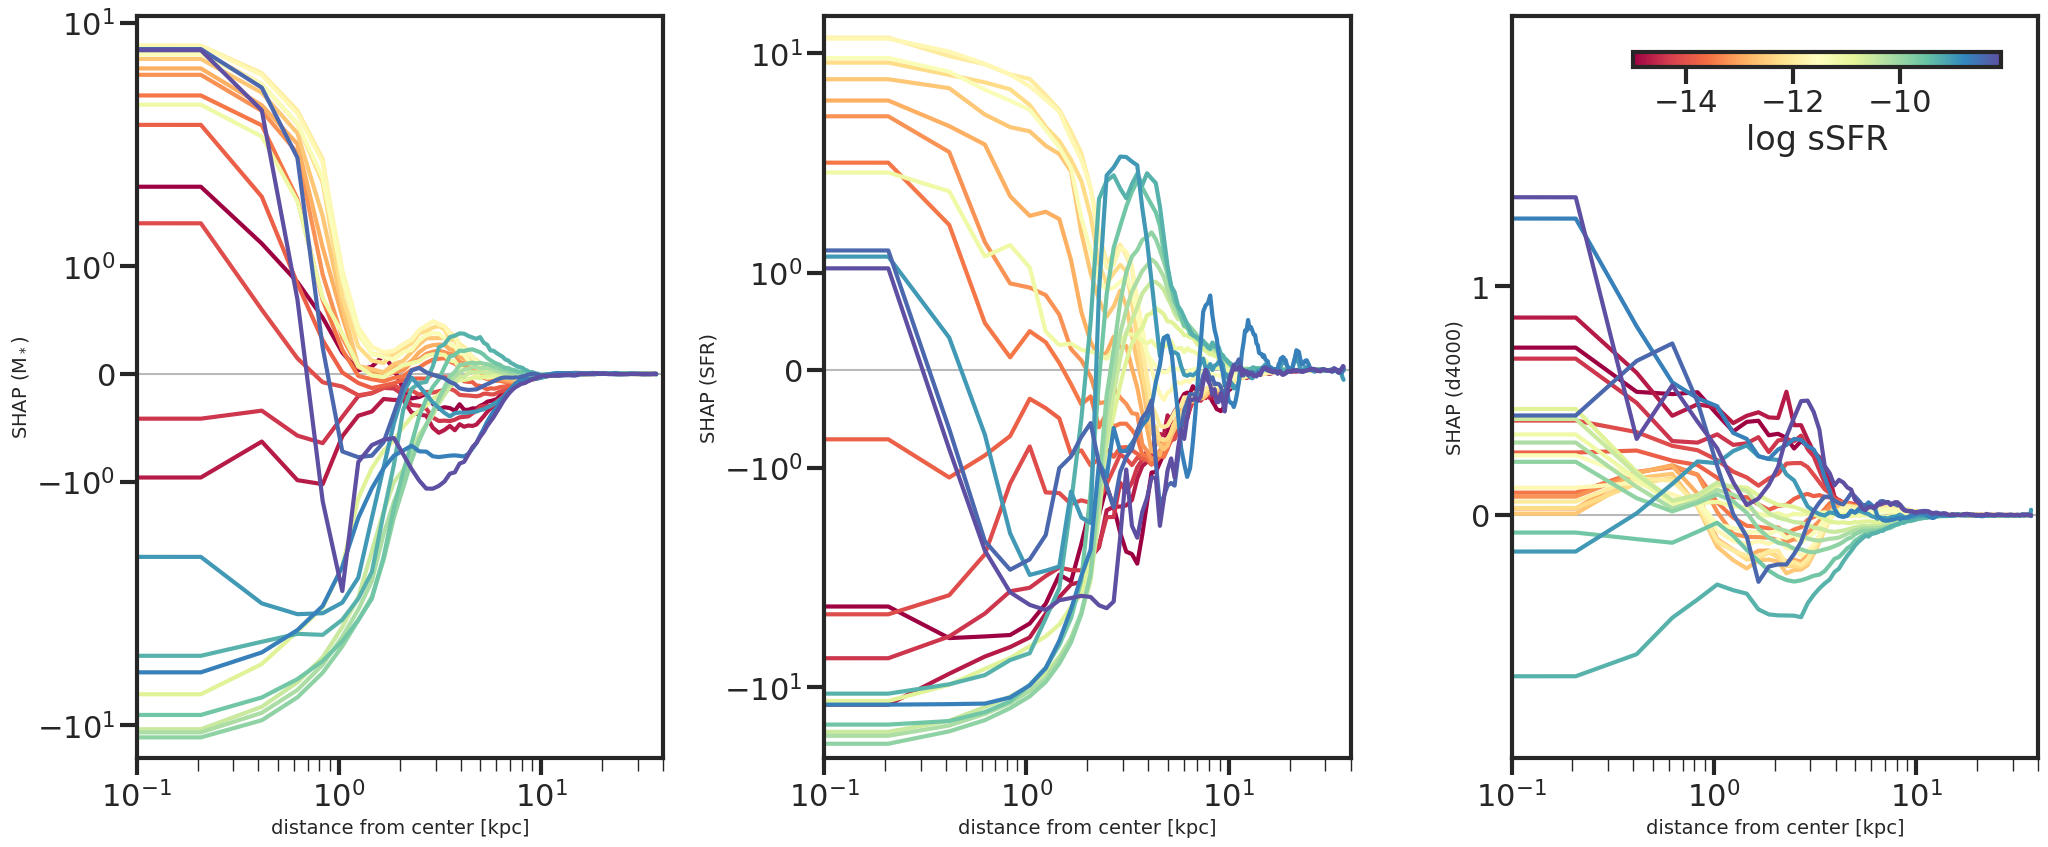

No galaxies in bin -8.699 - -8.399
No galaxies in bin -8.699 - -8.399


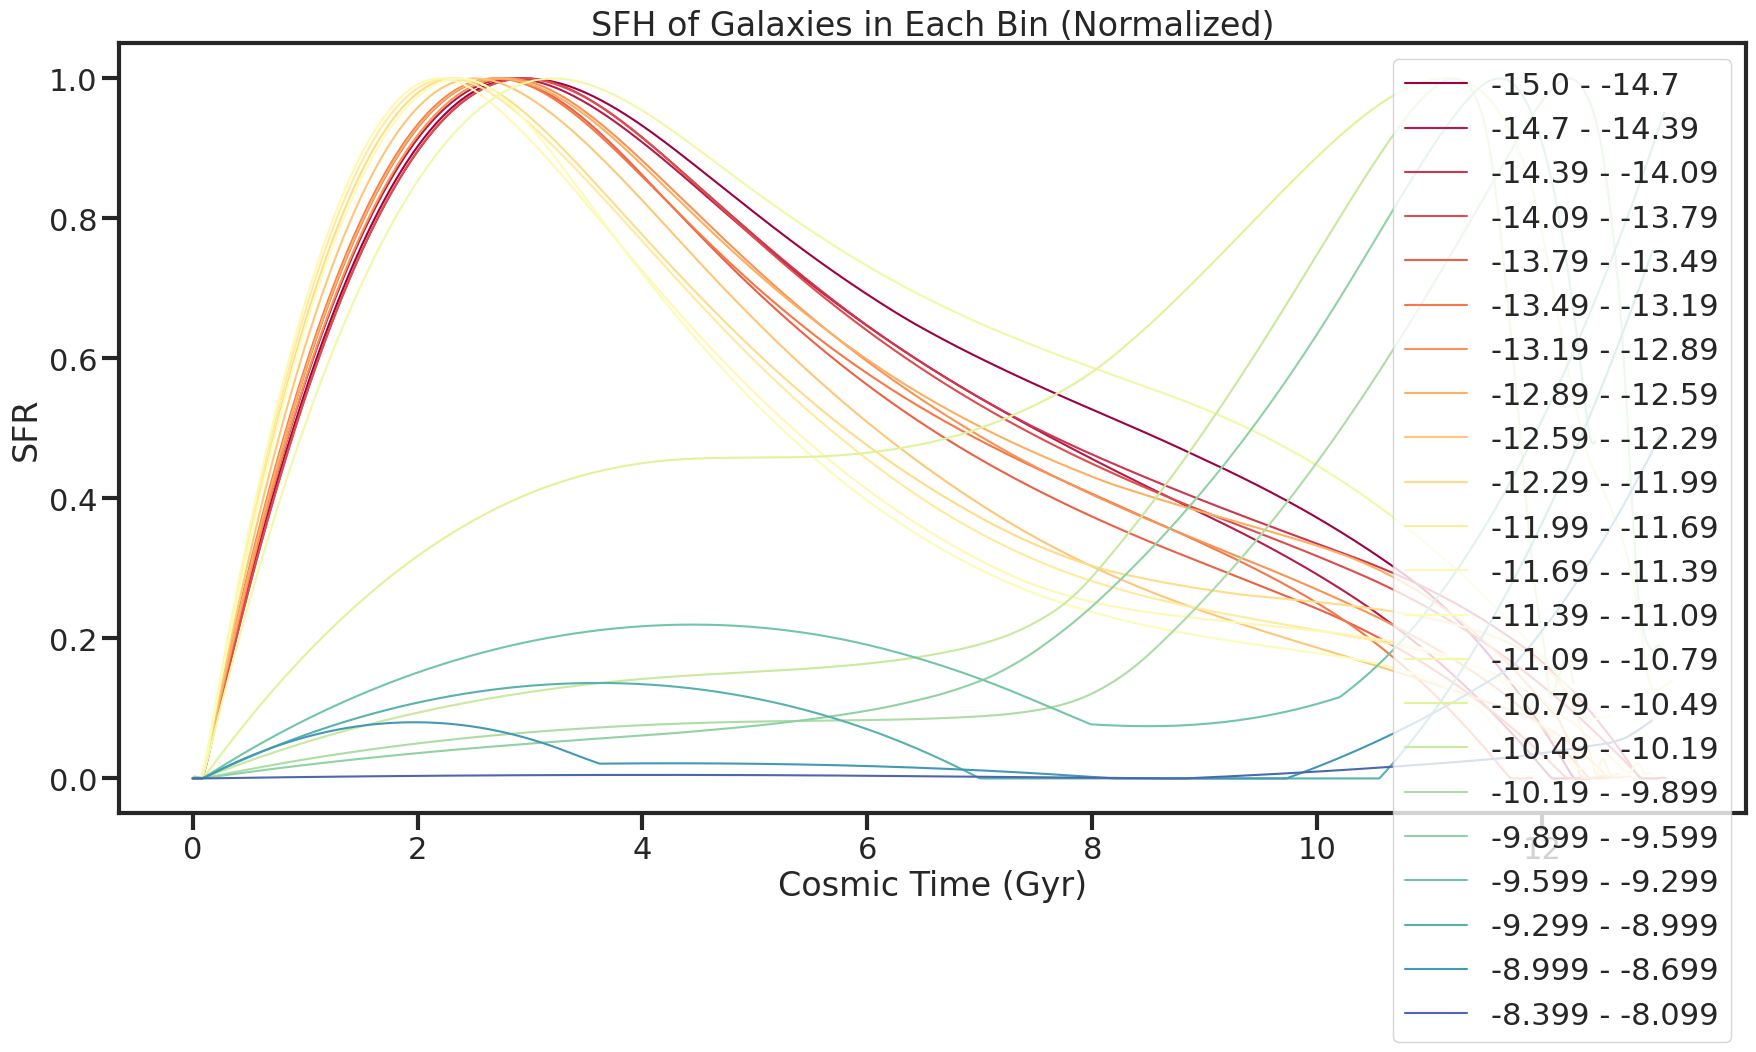

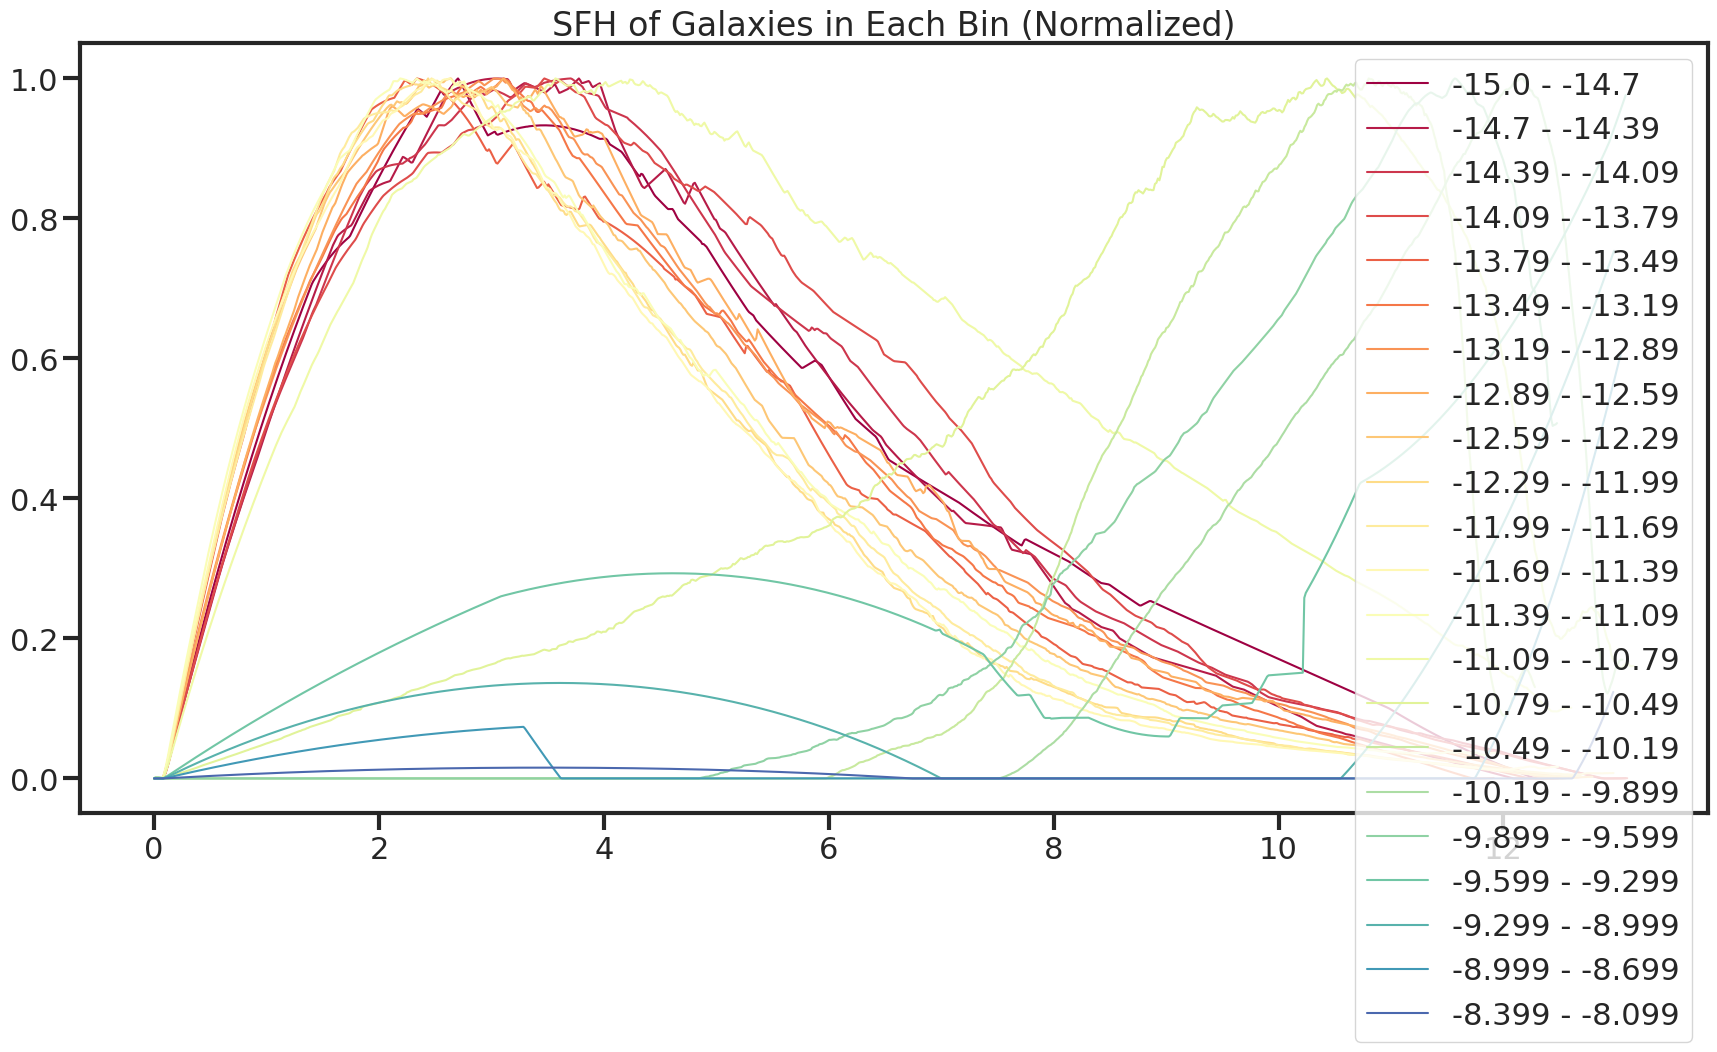

In [97]:
make_radial_shapplot(mv = manga_scalars['log_sfr'] - manga_scalars['log_mstar'], 
                     massbins = np.arange(-15,-8,0.3),
                     clabel = 'log sSFR')

SFH_plot(np.arange(-15,-8,0.3),'ssfr')
SFH_plot_median(np.arange(-15,-8,0.3),'ssfr')

# Secondary galaxy properties

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 


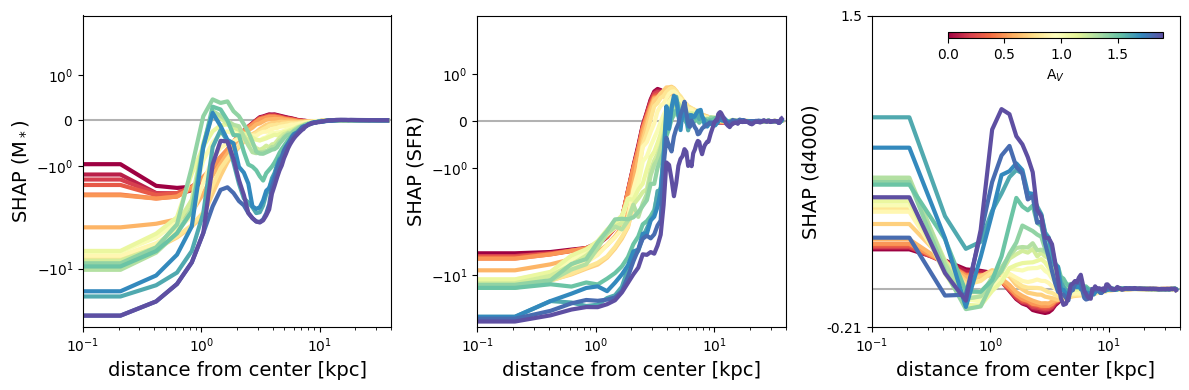

In [15]:
make_radial_shapplot(mv = manga_scalars['Av'], 
                     massbins = np.arange(0., 2.0,0.1),
                     clabel = 'A$_V$')

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 


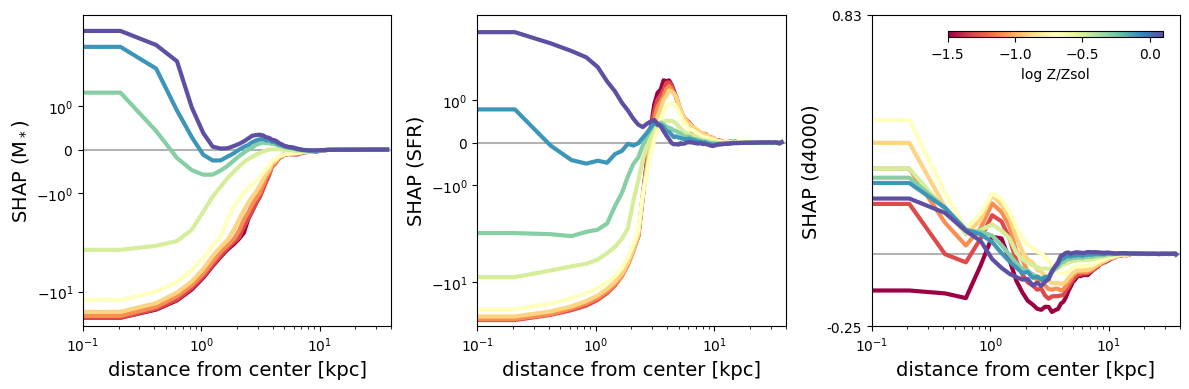

In [16]:
make_radial_shapplot(mv = manga_scalars['Z'], 
                     massbins = np.arange(-1.5,0.3,0.2),
                     clabel = 'log Z/Zsol')

# Morphological properties

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


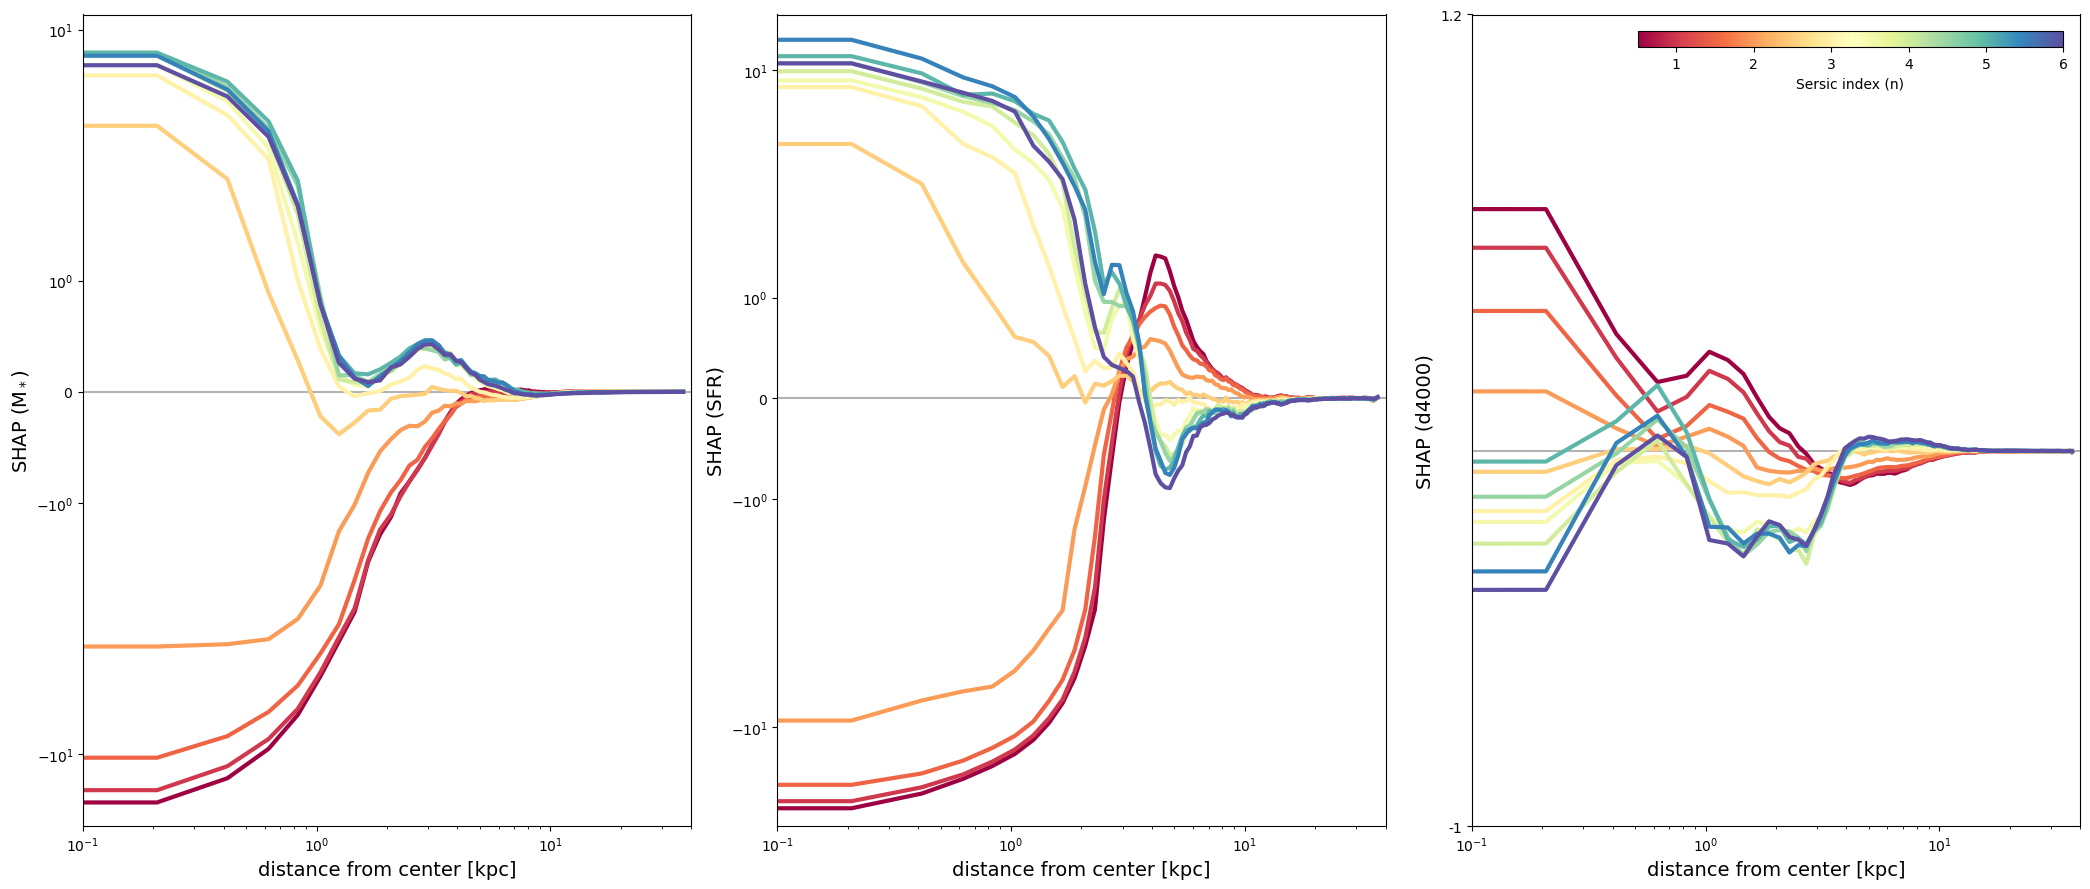

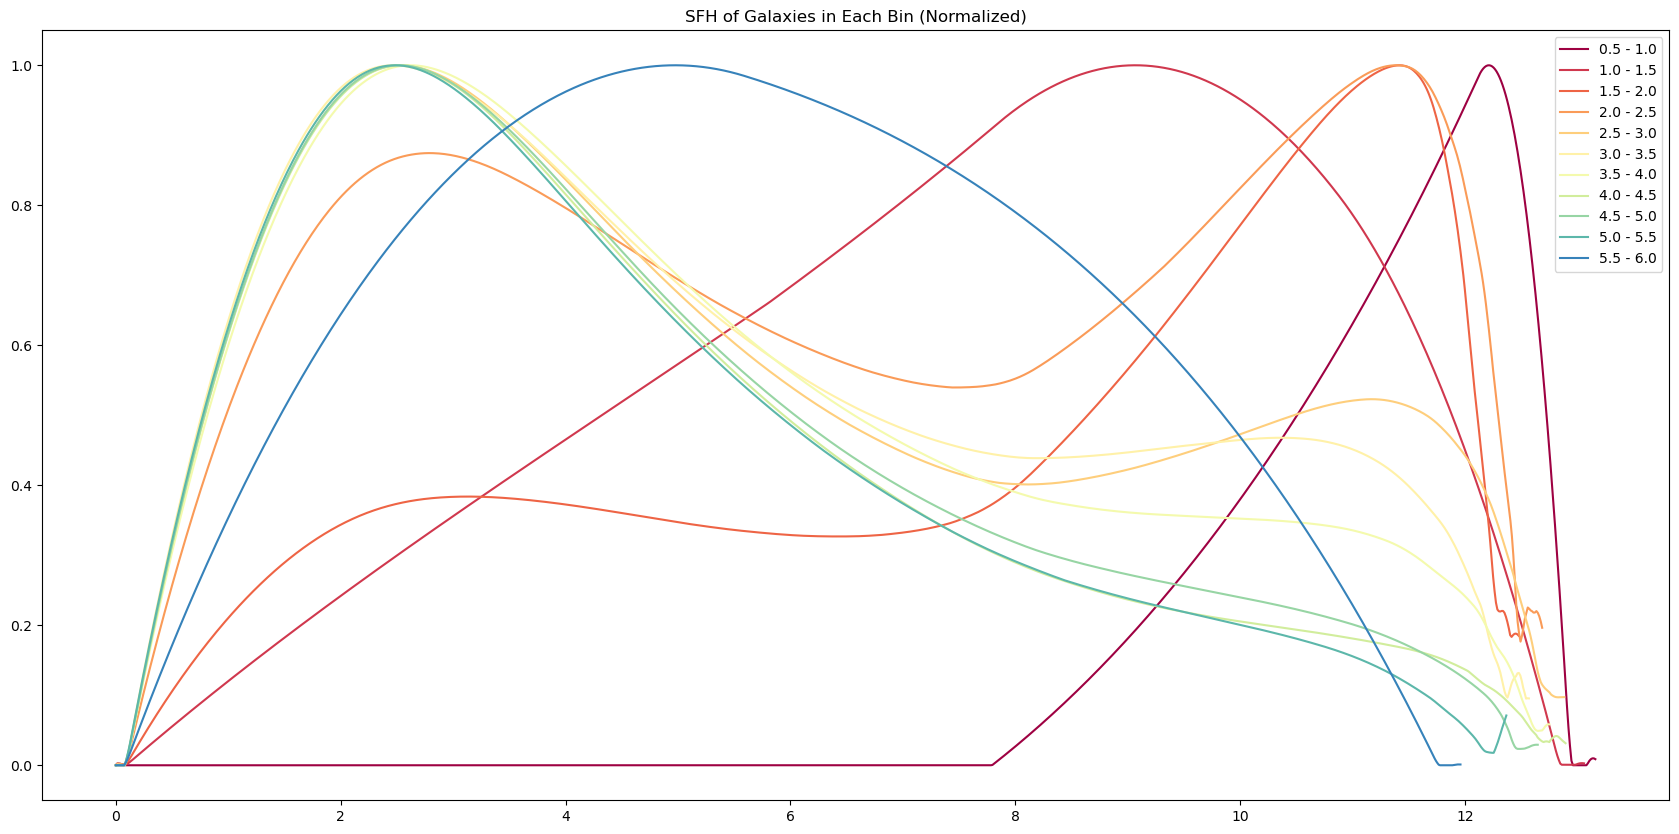

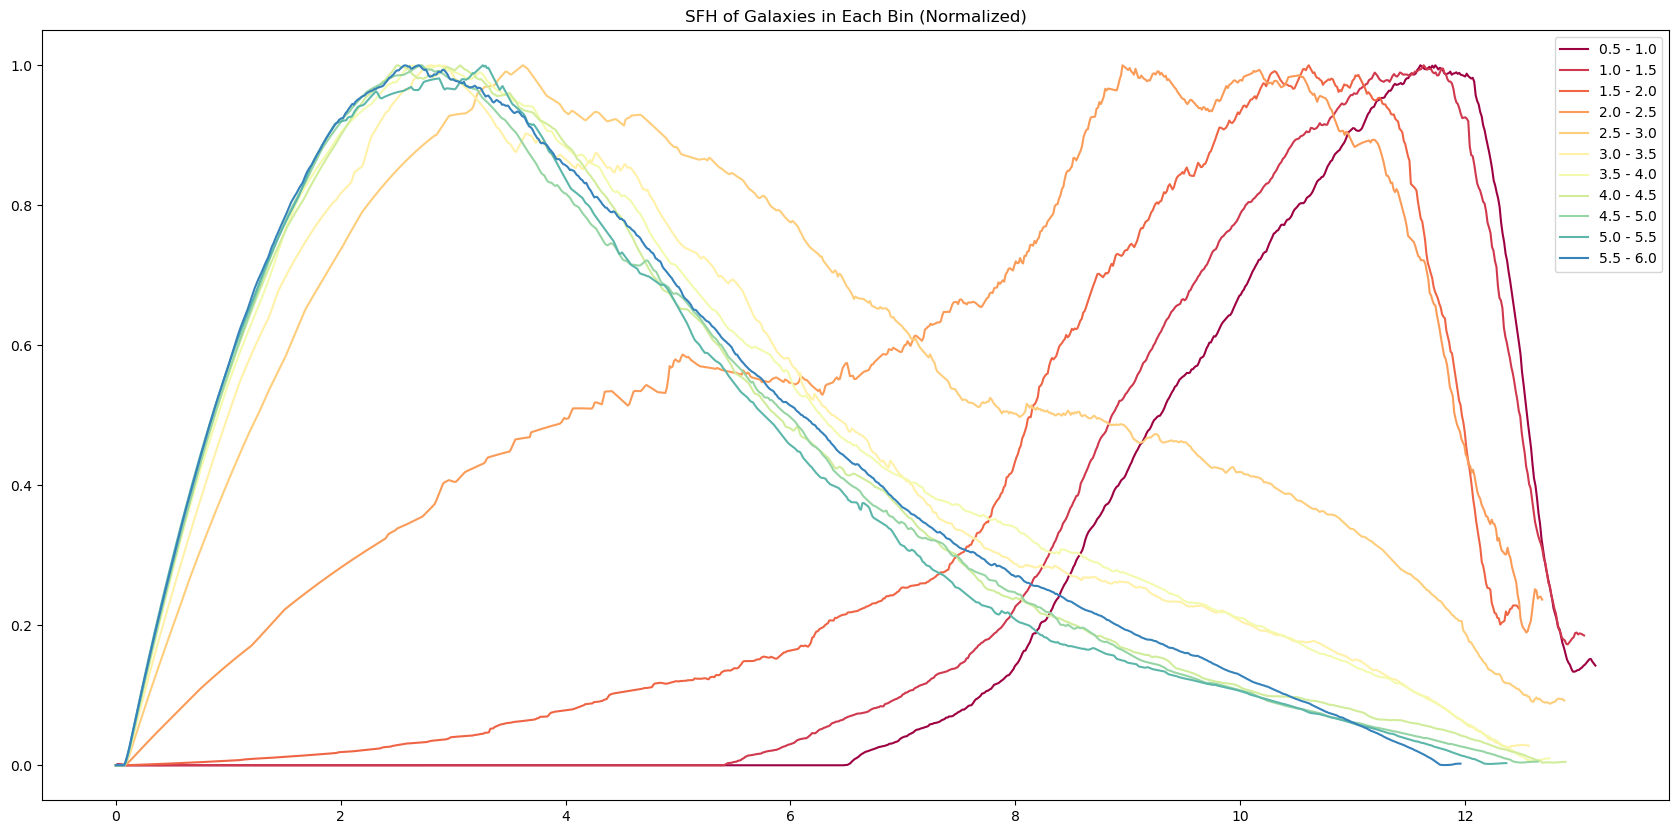

In [63]:
make_radial_shapplot(mv = manga_scalars['sersic_n'], 
                     massbins = np.arange(0.5,6.1,0.5), 
                     clabel = 'Sersic index (n)')

SFH_plot(np.arange(0.5,6.1,0.5),'sersic_n')
# SFH_plot_median(np.arange(0.5,6.1,0.5),'sersic_n')

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 


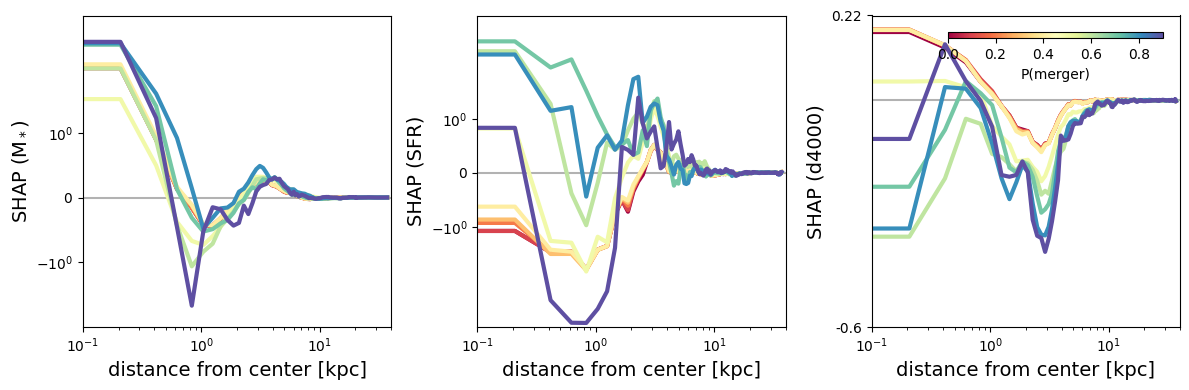

In [20]:
make_radial_shapplot(mv = manga_scalars['p_merger'], 
                     massbins = np.arange(0.0,1,0.1), 
                     clabel = 'P(merger)')

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


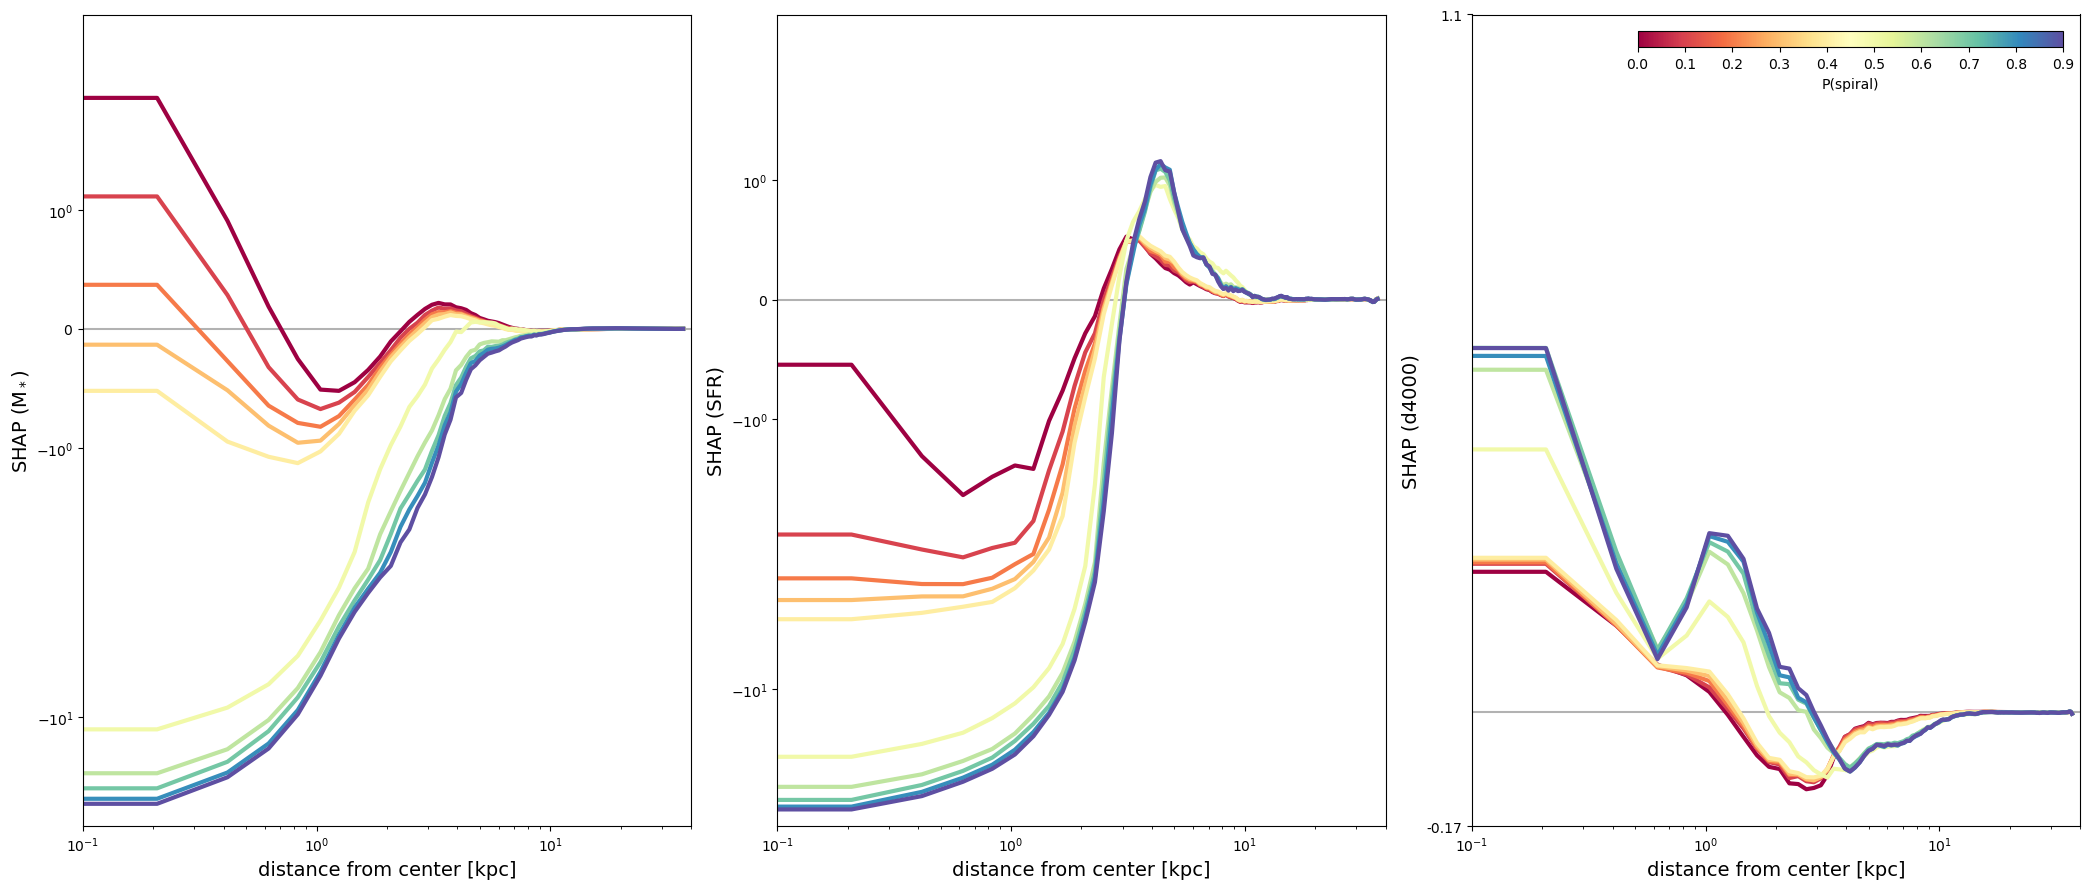

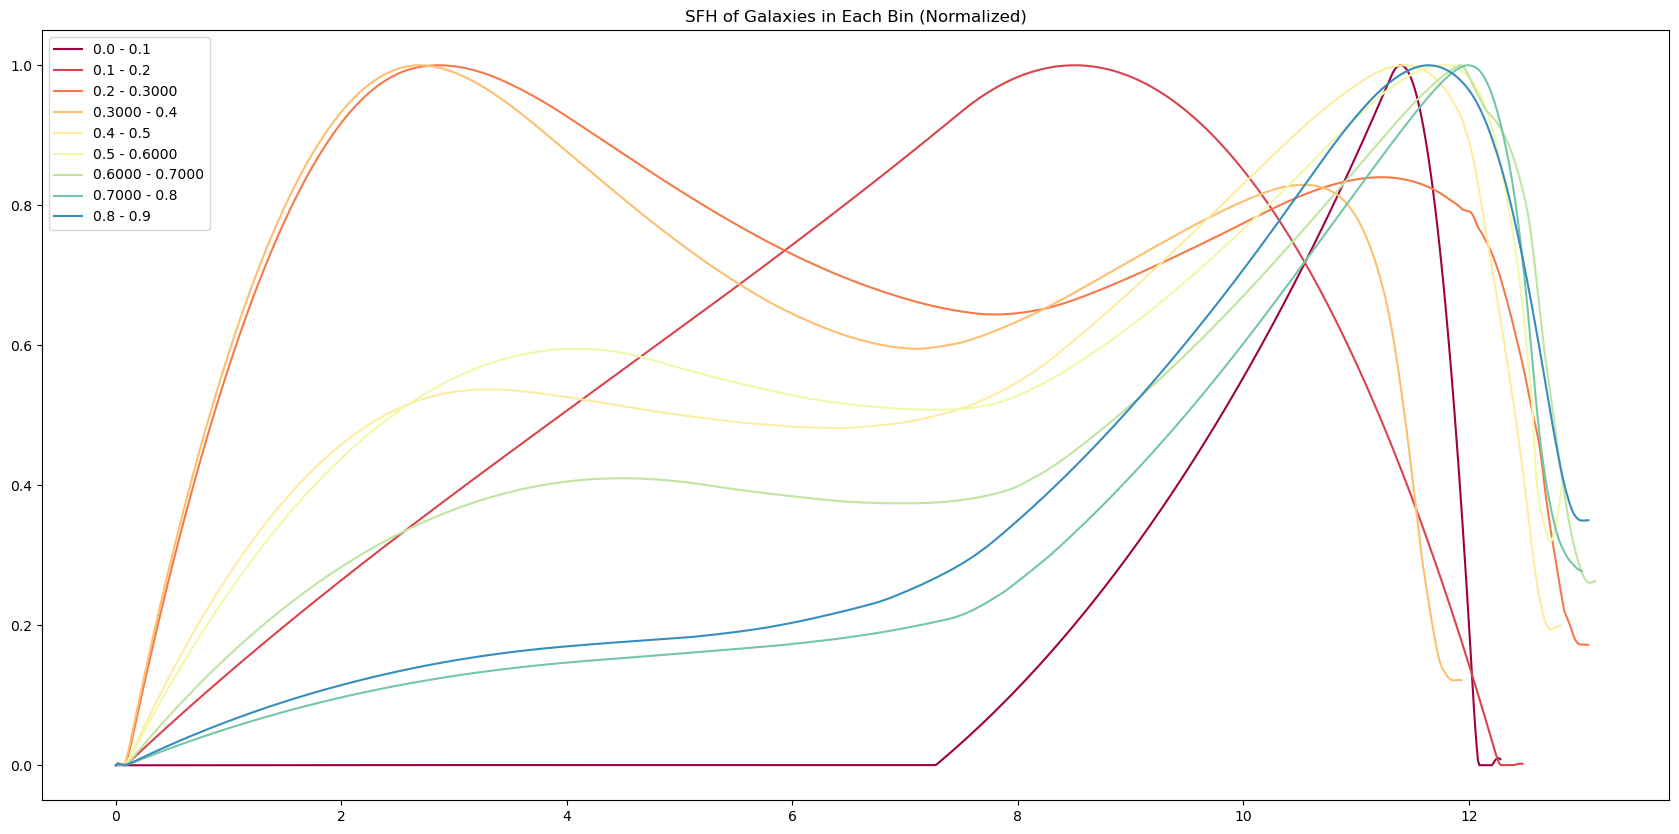

In [56]:
make_radial_shapplot(mv = manga_scalars['spirals'],
                     massbins = np.arange(0,1,0.1),
                     clabel = 'P(spiral)')

SFH_plot(np.arange(0,1,0.1),'spirals')

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


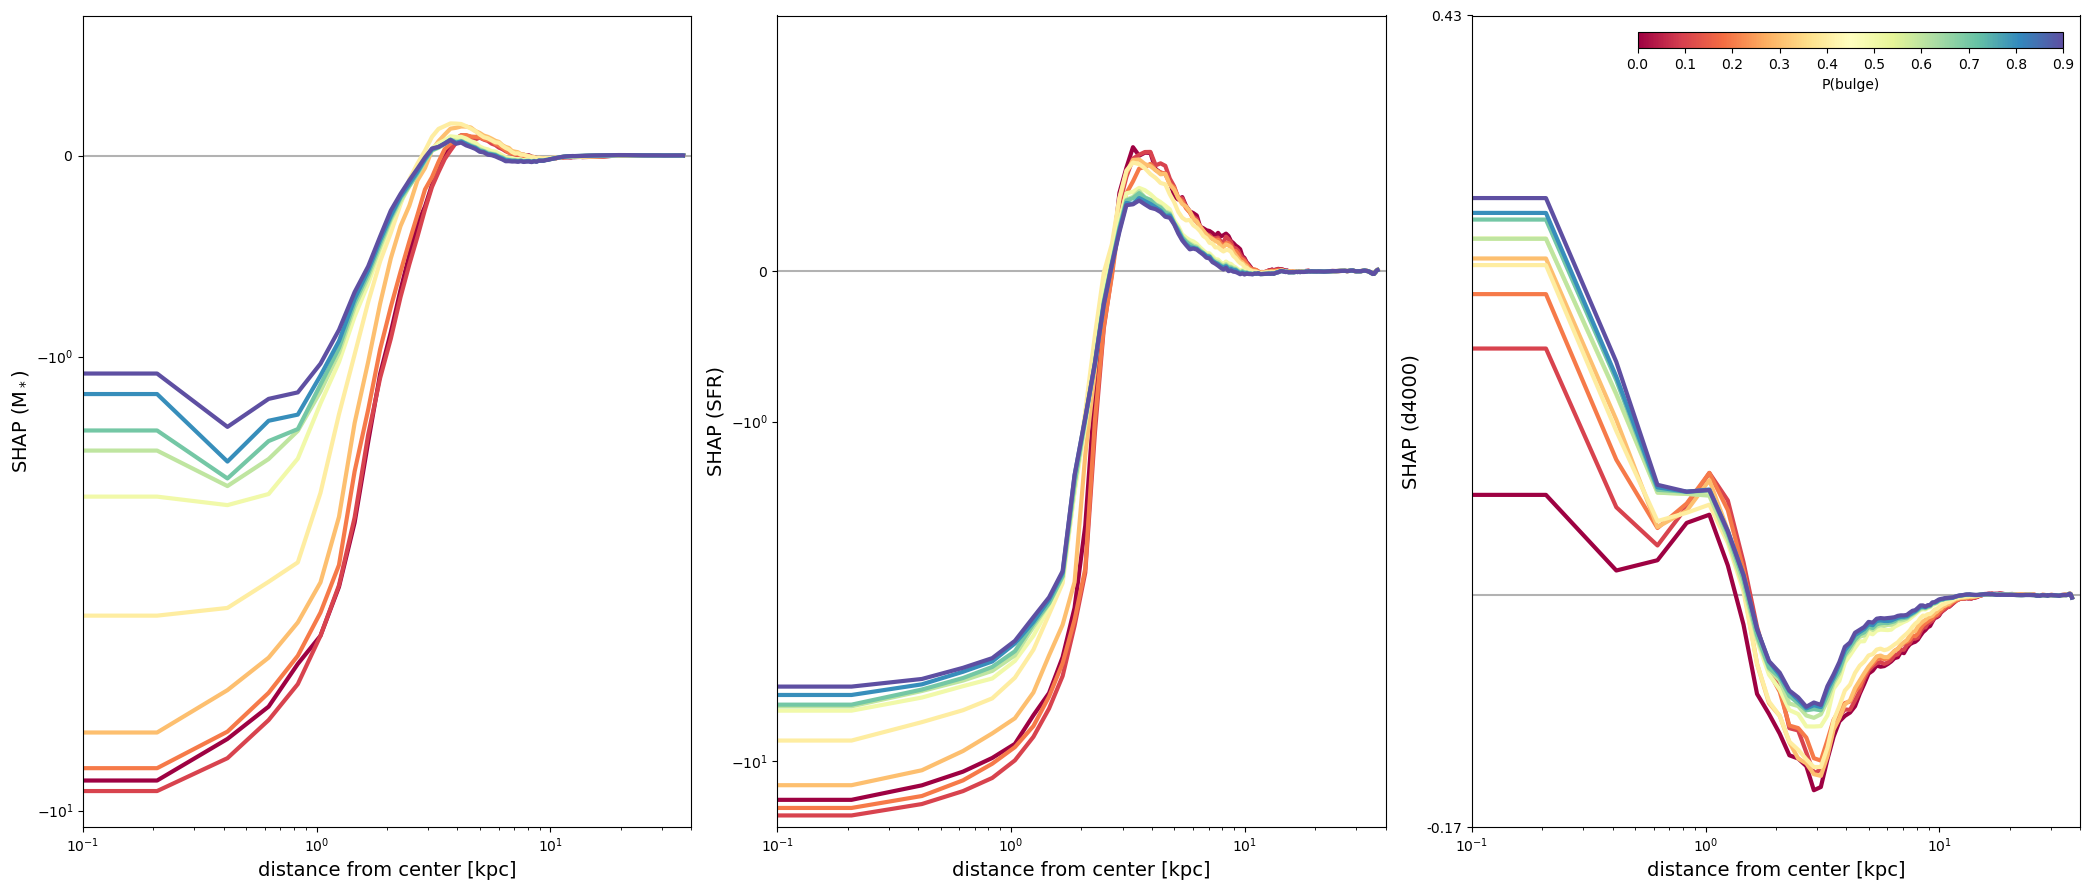

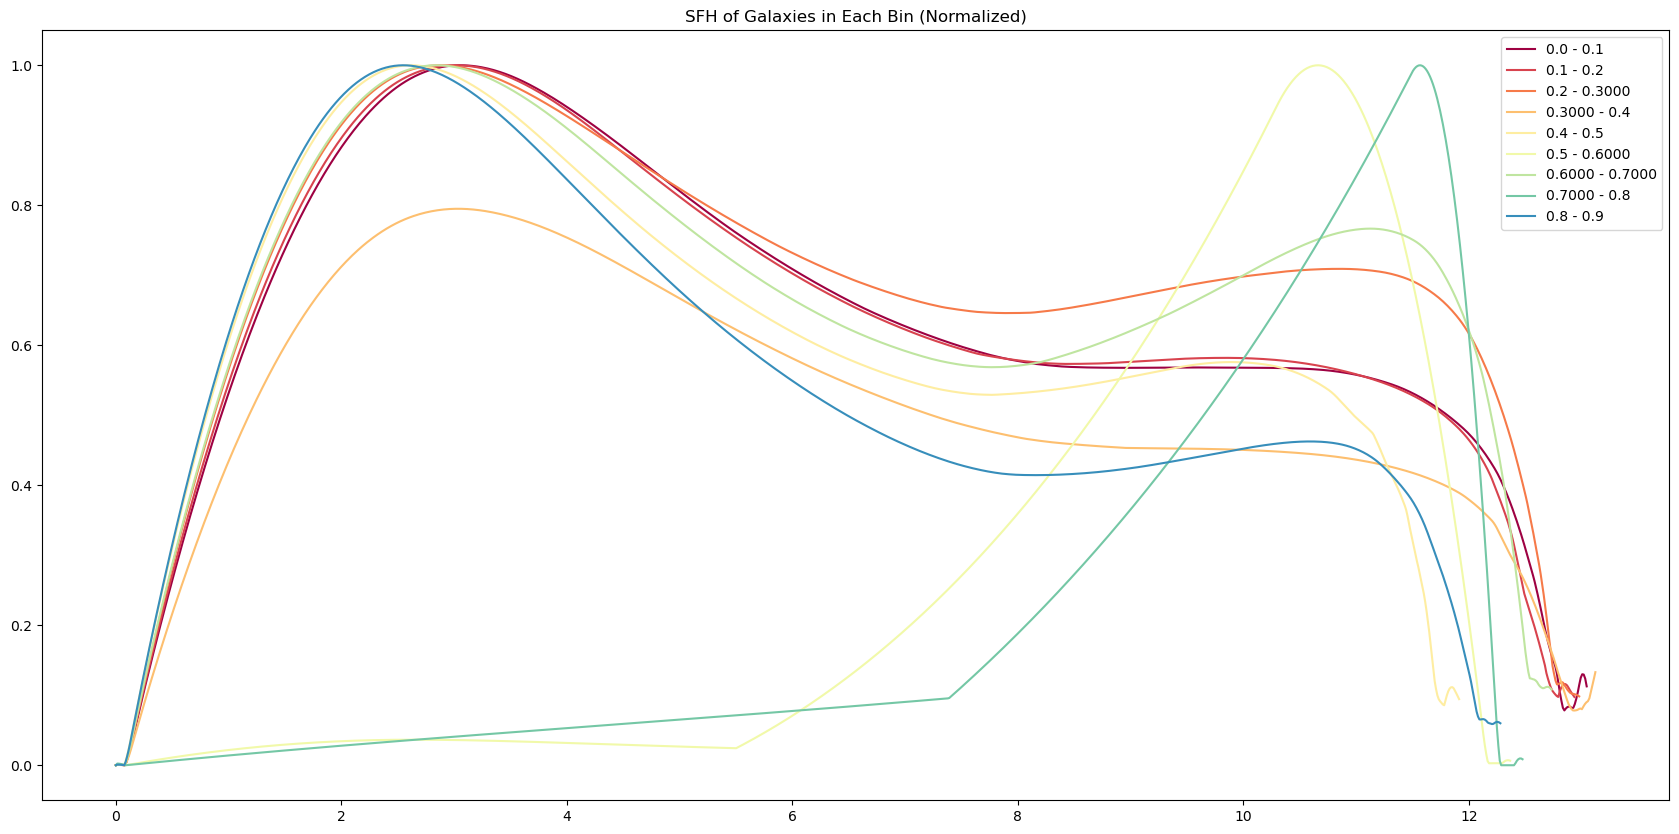

In [57]:
make_radial_shapplot(mv = manga_scalars['bulge'],
                     massbins = np.arange(0,1,0.1),
                     clabel = 'P(bulge)')

SFH_plot(np.arange(0,1,0.1),'bulge')

# Environmental variables

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 


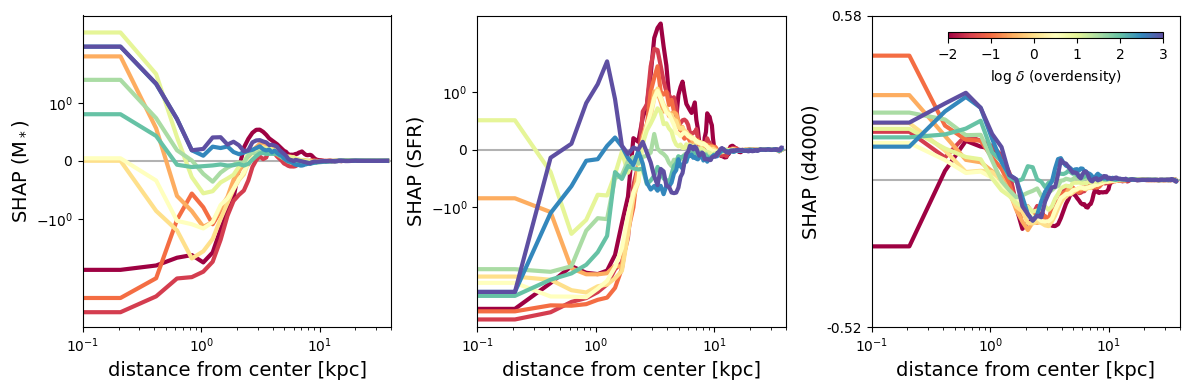

In [25]:
# might need to control for mass-\delta reln for this plot to show any actual signals

make_radial_shapplot(mv = np.log10(manga_scalars['over_density']), 
                     massbins = np.arange(-2,3.1,0.5), 
                     clabel = 'log $\delta$ (overdensity)')

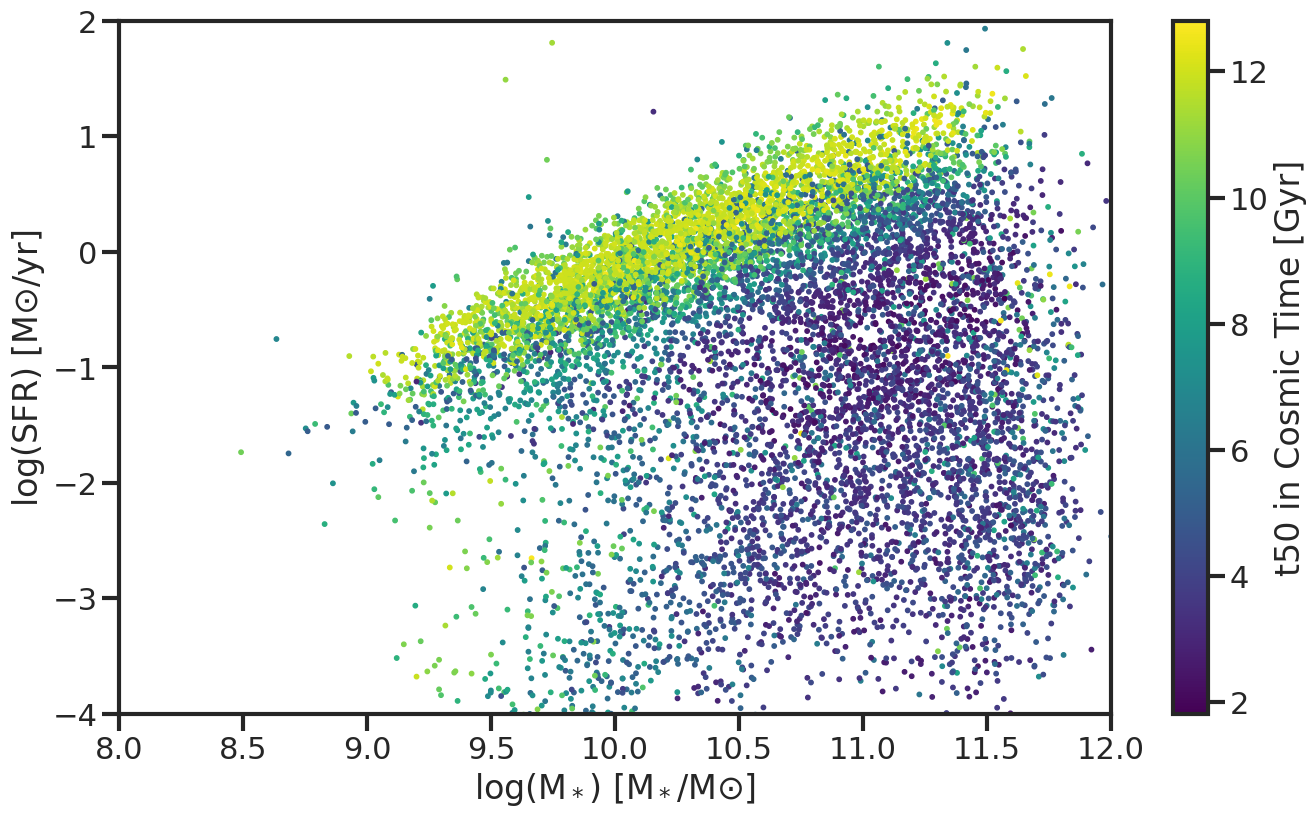

In [114]:
mask = np.where(manga_scalars['d4000'] <2 )[0]
plt.figure(figsize=(16,9))
plt.scatter(manga_scalars['log_mstar'].iloc[mask], manga_scalars['log_sfr'].iloc[mask], c=manga_scalars['t50_model'].iloc[mask], cmap='viridis', s=10)
plt.colorbar(label='t50 in Cosmic Time [Gyr]')
plt.xlabel(r'log(M$_*$) [M$_*$/M$\odot$]')
plt.ylabel(r'log(SFR) [M$\odot$/yr]')
plt.xlim(8,12)
plt.ylim(-4,2)
plt.savefig('manga_t50.pdf', dpi=300, bbox_inches='tight')

(-15.0, -9.0)

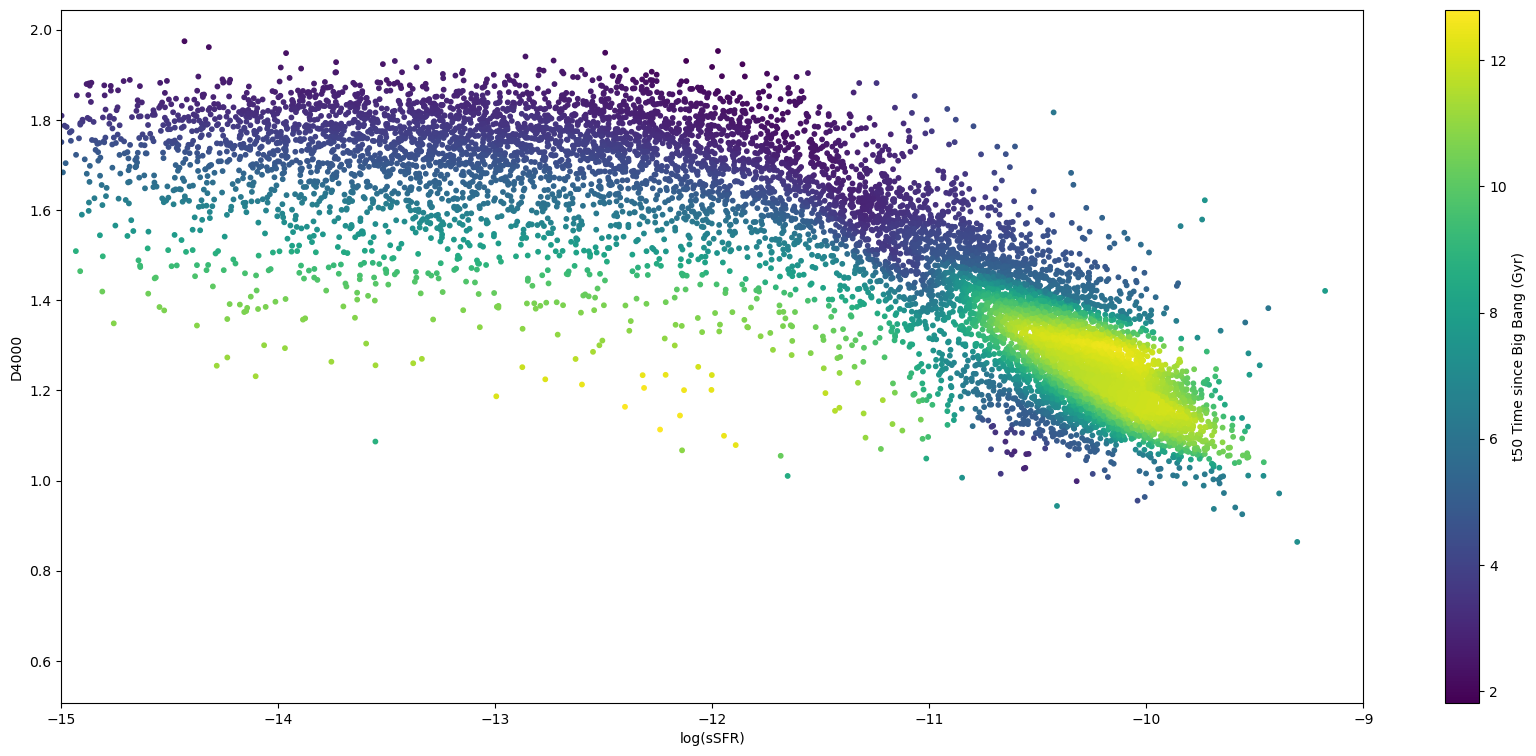

In [87]:
mask = np.where(manga_scalars['d4000'] <2 )[0]
plt.figure(figsize=(21,9))
plt.scatter(manga_scalars['log_sfr'].iloc[mask]- manga_scalars['log_mstar'].iloc[mask], manga_scalars['d4000'].iloc[mask], c=manga_scalars['t50_model'].iloc[mask], cmap='viridis', s=10)
plt.colorbar(label='t50 Time since Big Bang (Gyr)')
plt.xlabel('log(sSFR)')
plt.ylabel('D4000')
plt.xlim(-15,-9)
# plt.ylim(-4,2)

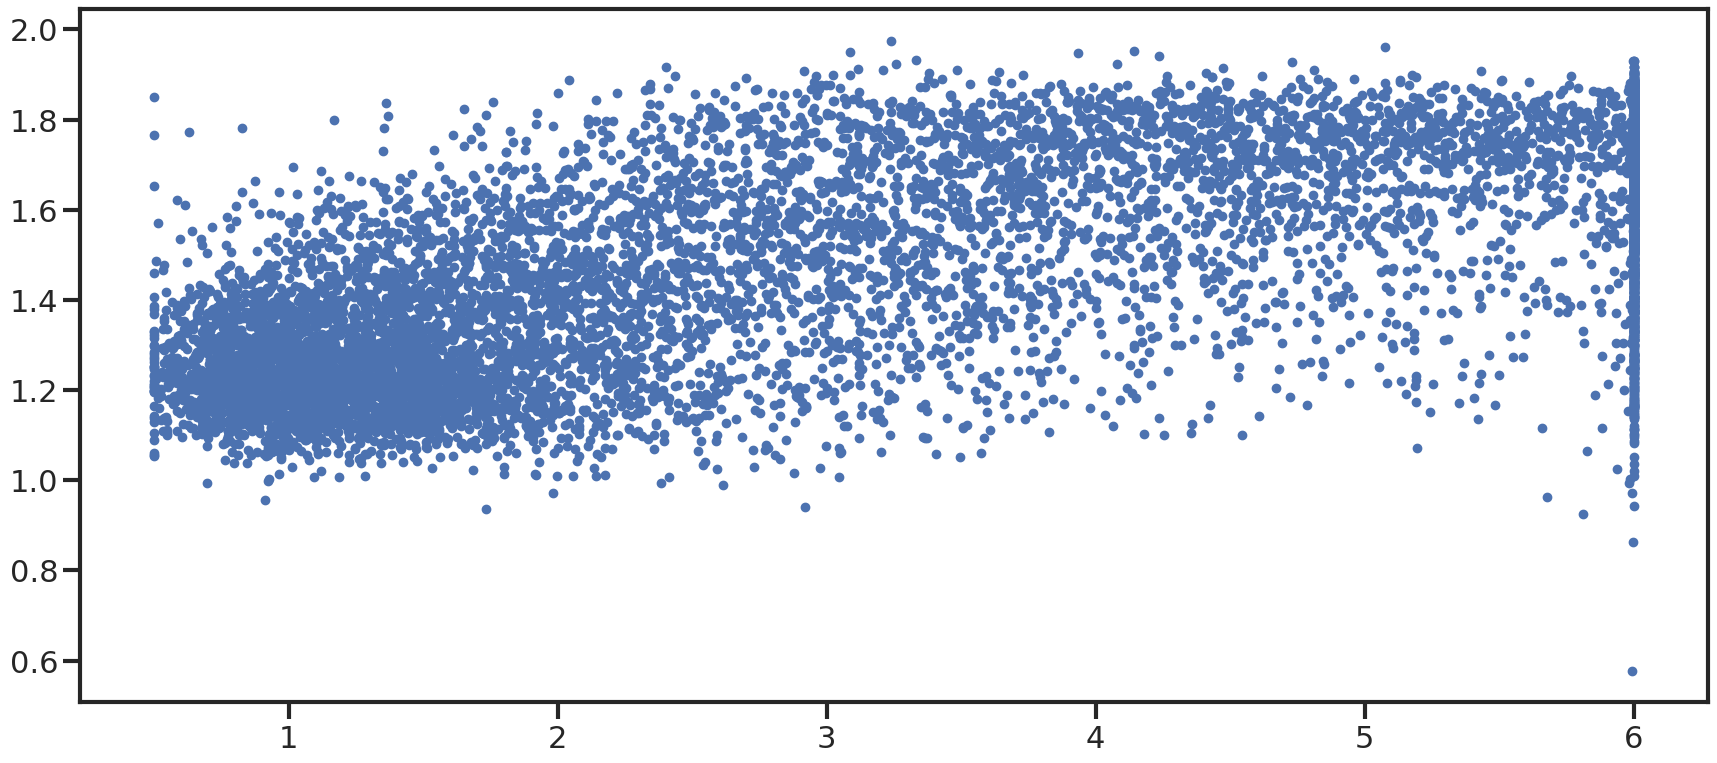

In [100]:
plt.figure(figsize=(21,9))
plt.scatter(manga_scalars['sersic_n'].iloc[mask],manga_scalars['d4000'].iloc[mask])